In [ ]:
# pip install opencv-python

In [1]:
import cv2
import os
import random
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
batch_size = 5  
lr_v = 2e-4
tot_sample= 100 
n_epoch = 500
n_epoch_init = n_epoch//10
save_dir = "samples"
checkpoint_dir = "models"
save_ind= 16
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [3]:
def load(path,shape):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, shape)
    return img
def get_data(path):
    X=[]
    Y=[]
    for folder in glob.glob(path+ str('/*')):
        for img_path in glob.glob(folder+ str('/*')):      
            if folder == os.path.join(path, 'HR'):
                X.append(load(img_path, (384, 384)))
            elif folder == os.path.join(path, 'LR'):
                Y.append(load(img_path, (96,96)))
    X= np.array(X)
    Y= np.array(Y)
    return X/255.0, Y/255.0

In [4]:
HR_train, LR_train= get_data('Data')
HR_train.shape, LR_train.shape

((100, 384, 384, 3), (100, 96, 96, 3))

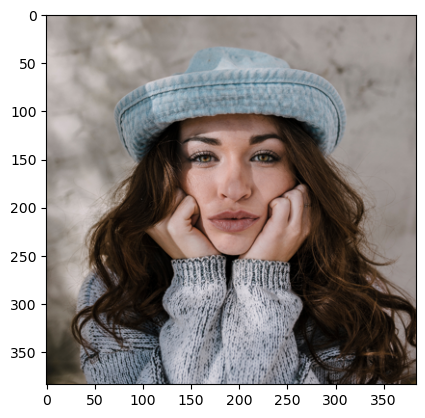

In [5]:
plt.imshow(HR_train[50])

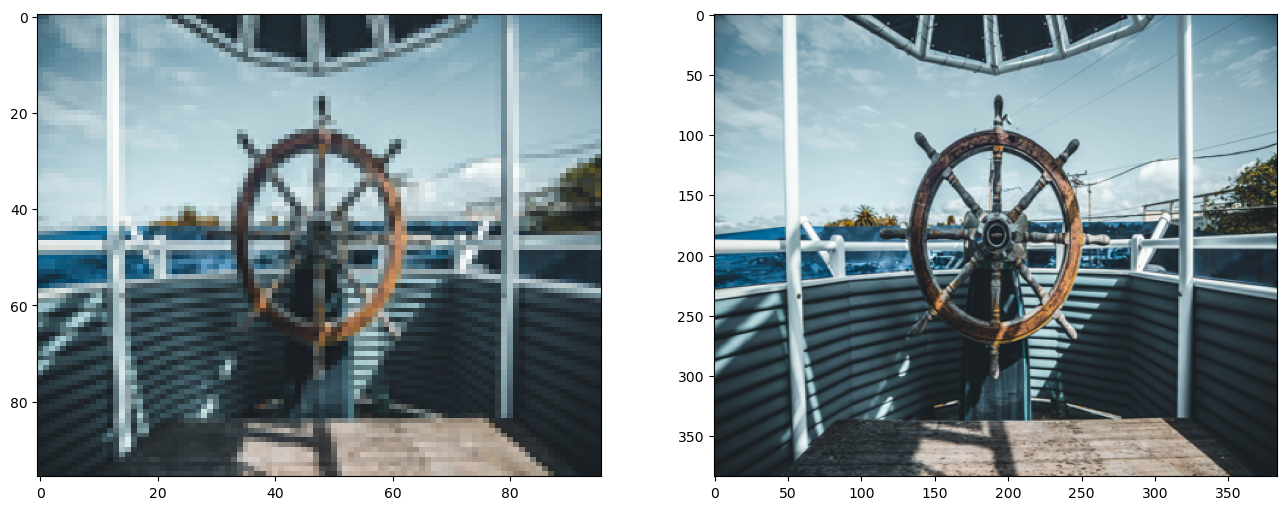

In [6]:
f, ax= plt.subplots(1,2, figsize=(16, 6))
ax[0].imshow(LR_train[save_ind], aspect='auto')
ax[1].imshow(HR_train[save_ind], aspect='auto')
plt.show()

GAN MODEL

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model

In [8]:
class SubpixelConv2D(Layer):
    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

In [9]:
#Generator
def get_G(input_shape):
    g_init = tf.random_normal_initializer(1., 0.02)
    relu= Activation('relu')

    nin= Input(shape= input_shape)
    n= Conv2D(64, (3,3), padding='SAME', activation= 'relu',
                        kernel_initializer='HeNormal')(nin)
    temp= n
    for i in range(3):
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)
        nn= relu(nn)
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)
        nn= add([n, nn])
        n= nn
        n= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= add([n, temp])
    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)
    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)
    nn= Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(n)
    G = Model(inputs=nin, outputs=nn, name="generator")
    return G
def get_D(input_shape):
    g_init= tf.random_normal_initializer(1., 0.02)
    ly_relu= LeakyReLU(alpha= 0.2)
    df_dim = 16
    nin = Input(input_shape)
    n = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(nin)
    n= ly_relu(n)
    for i in range(2, 6):
        n = Conv2D(df_dim*(2**i),(4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(n)
        n= ly_relu(n)
        n= BatchNormalization(gamma_initializer= g_init)(n)
    n= Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    temp= n
    n= Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= add([n, temp])
    n= Flatten()(n)
    no= Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(n)
    D= Model(inputs=nin, outputs=no, name="discriminator")
    return D
# VGG19
def get_vgg19():
    vgg= tf.keras.applications.VGG19( include_top=False, weights='imagenet', 
                                    input_tensor=None, input_shape=(384, 384, 3),
                                    pooling=None, classes=1000, classifier_activation='softmax' )
    inp= Input(shape=(384, 384, 3))
    x= vgg.layers[0](inp)
    for ly in vgg.layers[1:17]:
        x= ly(x)
    VGG19= Model(inp, x)
    return VGG19

# 2. Model Creation

In [10]:
G = get_G((96, 96, 3))
D = get_D((384, 384, 3))
vgg= get_vgg19()

In [11]:
g_optimizer_init = tf.optimizers.Adam(lr_v)
g_optimizer = tf.optimizers.Adam(lr_v)
d_optimizer = tf.optimizers.Adam(lr_v)
n_step_epoch = round(n_epoch_init // batch_size)
for epoch in range(n_epoch_init):
  i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
  if j== 0:
    j= -1
  X, Y= LR_train[i: j], HR_train[i: j]
  with tf.GradientTape() as tape:
      ypred= G(X)
      mse_loss= tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, ypred), axis=-1))
      grad = tape.gradient(mse_loss, G.trainable_weights)
      g_optimizer_init.apply_gradients(zip(grad, G.trainable_weights))        
  print("Epoch: [{}/{}] step: mse: {:.3f} ".format(
            epoch, n_epoch_init , mse_loss))
  if epoch%10 ==0:
    img= G.predict(LR_train[np.newaxis, save_ind])[0]
    img= Image.fromarray(np.uint8(img*255))
    img.save(os.path.join(save_dir, 'init_g_{}.png'.format(epoch)))

Epoch: [0/50] step: mse: 1.422 
1/1 [==============================] - 0s 333ms/step
Epoch: [1/50] step: mse: 1.242 
Epoch: [2/50] step: mse: 1.183 
Epoch: [3/50] step: mse: 1.071 
Epoch: [4/50] step: mse: 1.015 
Epoch: [5/50] step: mse: 1.031 
Epoch: [6/50] step: mse: 0.855 
Epoch: [7/50] step: mse: 0.919 
Epoch: [8/50] step: mse: 0.872 
Epoch: [9/50] step: mse: 0.727 
Epoch: [10/50] step: mse: 0.744 
1/1 [==============================] - 0s 107ms/step
Epoch: [11/50] step: mse: 0.745 
Epoch: [12/50] step: mse: 0.695 
Epoch: [13/50] step: mse: 0.680 
Epoch: [14/50] step: mse: 0.695 
Epoch: [15/50] step: mse: 0.597 
Epoch: [16/50] step: mse: 0.620 
Epoch: [17/50] step: mse: 0.588 
Epoch: [18/50] step: mse: 0.575 
Epoch: [19/50] step: mse: 0.582 
Epoch: [20/50] step: mse: 0.583 
1/1 [==============================] - 0s 108ms/step
Epoch: [21/50] step: mse: 0.507 
Epoch: [22/50] step: mse: 0.536 
Epoch: [23/50] step: mse: 0.506 
Epoch: [24/50] step: mse: 0.535 
Epoch: [25/50] step: mse: 

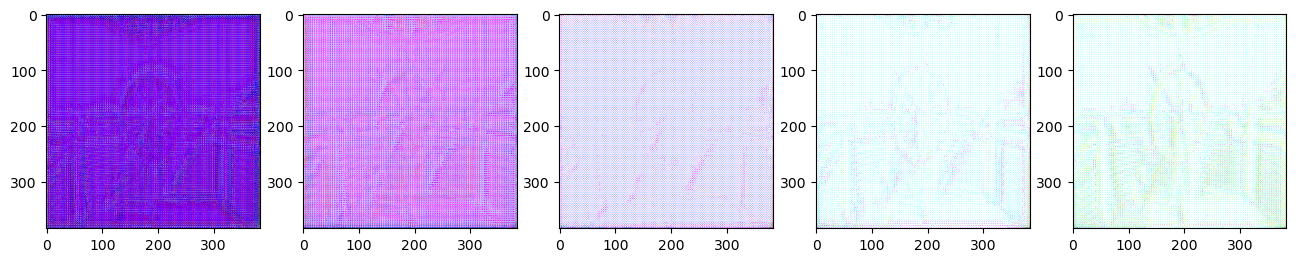

In [12]:
f, ax= plt.subplots(1,5, figsize=(16, 6))
for i, file in enumerate(glob.glob('./samples/init*')):
    img= load(file, shape=(384, 384))
    ax[i].imshow(img)
plt.show()    

In [ ]:
n_epoch= n_epoch-200
for epoch in range(n_epoch):
        i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
        if j== 0:
            j= -1
        X, Y= LR_train[i: j], HR_train[i: j]
        with tf.GradientTape(persistent=True) as tape:
            fake_img= G(X)
            fake_logits= D(fake_img)
            real_logits= D(Y)
            fake_feature= vgg(fake_img)
            real_feature= vgg(Y)
            d_loss1= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.zeros_like(fake_logits)))
            d_loss2= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits,tf.ones_like(real_logits)))
            d_loss= d_loss1 + d_loss2
            g_gan_loss= 2e-3*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.ones_like(fake_logits)))
            mse_loss=  2e-1* tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1))
            g_loss = mse_loss + vgg_loss + g_gan_loss
            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
        print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(
                epoch, n_epoch , d_loss, g_loss))
        if epoch%20 ==0:
            img= G.predict(LR_train[np.newaxis, save_ind])[0]
            img= Image.fromarray(np.uint8(img*255))
            img.save(os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))

Epoch: [0/300] step: D.loss: 1.752: G.loss: 0.093
1/1 [==============================] - 0s 117ms/step
Epoch: [1/300] step: D.loss: 1.009: G.loss: 0.097
Epoch: [2/300] step: D.loss: 1.006: G.loss: 0.087
Epoch: [3/300] step: D.loss: 1.007: G.loss: 0.078
Epoch: [4/300] step: D.loss: 1.006: G.loss: 0.087
Epoch: [5/300] step: D.loss: 1.006: G.loss: 0.069
Epoch: [6/300] step: D.loss: 1.006: G.loss: 0.085
Epoch: [7/300] step: D.loss: 1.006: G.loss: 0.073
Epoch: [8/300] step: D.loss: 1.006: G.loss: 0.079
Epoch: [9/300] step: D.loss: 1.006: G.loss: 0.085
Epoch: [10/300] step: D.loss: 1.006: G.loss: 0.081
Epoch: [11/300] step: D.loss: 1.006: G.loss: 0.074
Epoch: [12/300] step: D.loss: 1.006: G.loss: 0.064
Epoch: [13/300] step: D.loss: 1.006: G.loss: 0.072
Epoch: [14/300] step: D.loss: 1.006: G.loss: 0.087
Epoch: [15/300] step: D.loss: 1.006: G.loss: 0.061
Epoch: [16/300] step: D.loss: 1.006: G.loss: 0.076
Epoch: [17/300] step: D.loss: 1.006: G.loss: 0.065
Epoch: [18/300] step: D.loss: 1.006: G.

In [ ]:
f, ax= plt.subplots(3,5, figsize=(14, 16))
for i, file in enumerate(glob.glob('./samples/train*')[:15]):
    img= load(file, shape=(384, 384))
    ax[i//5][i%5].imshow(img, aspect='auto')
plt.show() 

In [ ]:
f, ax= plt.subplots(1,3, figsize=(16, 6))
ax[0].imshow(LR_train[save_ind], aspect='auto')
ax[1].imshow(load(glob.glob('./samples/train*')[-1], (384, 384)), aspect='auto')
ax[2].imshow(HR_train[save_ind], aspect='auto')
plt.show()